# 4. Time-varying beta functions

Far from being limited to static beta values, we can also simulate the affects of a time-and-location-varying beta function. For this demo, we'll use the State-level GEO we defined in Part 2.

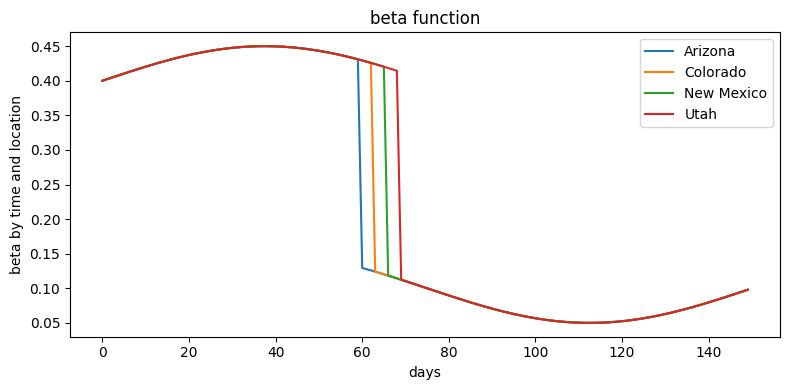

In [1]:
from math import pi, sin

import matplotlib.pyplot as plt

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.params import ParamFunctionTimeAndNode
from epymorph.simulator.data import evaluate_param

# Our function will be a sinusoid with a precipitous drop after 60 days,
# staggered by 3 days for each location.


class Beta(ParamFunctionTimeAndNode):
    def evaluate1(self, day, node_index):
        # The arguments of this function are
        # `day` -- the current simulation day, and
        # `node_index` -- the current geo node.
        # This formuluation allows us to vary the parameter over time and geo node.
        total_days = self.dim.days
        value = 0.40 + 0.05 * sin(2 * pi * day / total_days)
        cutoff = 60 + (node_index * 3)
        if day >= cutoff:
            value -= 0.30
        return value


geo = load_from_cache('demo-four-states')
if geo is None:
    raise Exception(
        "Can't load the demo-four-states geo from cache; see demo part 2 for that.")

# Now we create a simulation, passing in our beta function.
rume = Rume.single_strata(
    ipm=ipm_library['sirh'](),
    mm=mm_library['pei'](),
    scope=geo.spec.scope,
    params={
        'beta': Beta(),
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'move_control': 0.9,
        'theta': 0.1,
        'population': geo['population'],
        'commuters': geo['commuters'],
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

# Now plot the beta function. We can evaluate the data series for beta in this RUME.
# This way we can be sure we're plotting beta exactly as the simulation will see it.
beta_values = evaluate_param(rume, 'beta')
fig, ax = plt.subplots(figsize=(8, 4))
ax.set(title='beta function', ylabel='beta by time and location', xlabel='days')
ax.plot(beta_values, label=geo['label'])
ax.legend()
fig.tight_layout()
plt.show()

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.116s


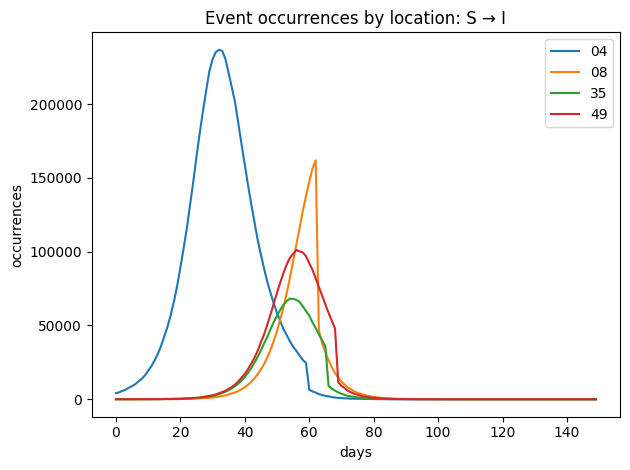

In [2]:
from epymorph import *

# Nothing changed from the simulation we declared above, so let's use that to run it.
sim = BasicSimulator(rume)
with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = rume.ipm.events_by_dst("I")[0]

plot_event(output, event_idx=EVENT_S_TO_I)